In [13]:
# import
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from PIL import Image
import shutil

# costants
SEED = 0xDED

target_w = 256
target_h = 256

batch_size = 8

use_crop = False

print(os.getcwd())

/kaggle/working


In [14]:
# intialization and common utilities

tf.random.set_seed(SEED)
np.random.seed(SEED)

def fromCwd(path):
    return os.path.join(os.getcwd(), path)

# train_dir = fromCwd("training")
# valid_dir = fromCwd("validation")
# data_dir = fromCwd("data")
# temp_dir = fromCwd("temp")

train_dir = os.path.join("/kaggle/working","training")
valid_dir = os.path.join("/kaggle/working","validation")
data_dir = os.path.join("/kaggle/input/contadinoset/Development_Dataset","Training")
temp_dir = os.path.join("/kaggle/working","temp")

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    os.mkdir(valid_dir)
    


In [15]:
# crop image

# make crops and return the sub images
def cropImg(image, target_w, target_h):
    w, h = image.size
    div_x = int(w/target_w)
    div_y = int(w/target_h)
    if div_x <= 0:
        div_x = 1
    if div_y <= 0:   
        div_y = 1
    

    w /= div_x
    h /= div_y

    sub_images = []
    # x and y are swapped to have array "rows" match image rows
    for y in range(div_y):
        for x in range(div_y):
            sz = (x*w, y*h, x*w + w, y*h + h)
            sub_images.append(image.crop(sz))

    return sub_images

#save images to disk
def saveImagesArray(images, original_name, dest_dir):
    filename, file_extension = os.path.splitext(original_name)
    for i in range(len(images)):
        img = images[i]
        w, h = img.size
        img.save(os.path.join(dest_dir, filename + "_cp" + str(i) + "_" + str(w) + "x" + str(h) + "." + file_extension))

# recursively crop all images into a directory maitaining the same
# internal structure to the destination
def cropAllTo(source_dir, dest_dir, target_w, target_h):
    if(os.path.exists(dest_dir)):
        print("[Skipped] Directory already exists: "+ dest_dir)
        return
    else:
        os.mkdir(dest_dir)

    # iterate all files and check if directory or not
    for fl in os.listdir(source_dir): # return relative paths
        if os.path.isdir(os.path.join(source_dir, fl)):
            # start again with the new source as the dir path
            cropAllTo(os.path.join(source_dir, fl), os.path.join(dest_dir, fl), target_w, target_h) 
        else:
            im = Image.open(os.path.join(source_dir, fl))
            # here we got an image and se shold split it and save
            images = cropImg(im, target_w, target_h)
            saveImagesArray(images, fl, dest_dir)
    print("Generated " + dest_dir)


# move all data to images or mask folders into dest dir
def moveRecursive(source_dir, folders, percent):
    print(folders)
    
    items = os.listdir(source_dir)
    print("Moving from "+ source_dir)

    if not "Images" in items: # normal top folder we should explore all its sub folders
        for fold in items:
            moveRecursive(os.path.join(source_dir, fold), folders, percent)
        return # no more to do in this folder

    # here we got Images in subfolder
    im_dir = os.path.join(source_dir, "Images")
    ms_dir = os.path.join(source_dir, "Masks")
    # read all images and masks
    images = os.listdir(im_dir)
    masks = os.listdir(ms_dir)

    # make validation
    for i in range(int(len(images) * percent)):
        idx = np.random.randint(0, len(images))

        # move both image and mask to validation folder
        os.rename(os.path.join(im_dir, images[idx]), os.path.join(folders[2], images[idx]))
        os.rename(os.path.join(ms_dir, masks[idx]), os.path.join(folders[3], masks[idx]))

        # update refreshed folders without moved elements
        images = os.listdir(im_dir)
        masks = os.listdir(ms_dir)

    # create train set
    for img in images:
        os.rename(os.path.join(im_dir, img), os.path.join(folders[0], img))
    for msk in masks:
        os.rename(os.path.join(ms_dir, msk), os.path.join(folders[1], msk))

    


# move all data from subfolders in source folder to Images/Mask folders in dest folder
def prepareTrainData(source_dir, train_dir, valid_dir, percent = 0.1):

    folders = [] # order: Test_img | Test_mask | valid_img | valid_mask
    for parent in [train_dir, valid_dir]:
        for sub in ["Images", "Masks"]:
            folders.append(os.path.join(parent,sub))

    # check if a folder already exist and skip 
    for f in folders:
        if os.path.exists(f):
            print("[Skipped] Directory already exists: "+ f)
            return folders

    # create folders
    for f in folders:   
        os.makedirs(f)

    moveRecursive(source_dir, folders, percent)
    print("Train and Valid set ready")

    return folders


if not os.path.exists(temp_dir):
    shutil.copytree(data_dir, temp_dir) # required to copy everythin because preparaTrainData move images

folders = prepareTrainData(temp_dir, train_dir, valid_dir)

['/kaggle/working/training/Images', '/kaggle/working/training/Masks', '/kaggle/working/validation/Images', '/kaggle/working/validation/Masks']
Moving from /kaggle/working/temp
['/kaggle/working/training/Images', '/kaggle/working/training/Masks', '/kaggle/working/validation/Images', '/kaggle/working/validation/Masks']
Moving from /kaggle/working/temp/Pead
['/kaggle/working/training/Images', '/kaggle/working/training/Masks', '/kaggle/working/validation/Images', '/kaggle/working/validation/Masks']
Moving from /kaggle/working/temp/Pead/Haricot
['/kaggle/working/training/Images', '/kaggle/working/training/Masks', '/kaggle/working/validation/Images', '/kaggle/working/validation/Masks']
Moving from /kaggle/working/temp/Pead/Mais
['/kaggle/working/training/Images', '/kaggle/working/training/Masks', '/kaggle/working/validation/Images', '/kaggle/working/validation/Masks']
Moving from /kaggle/working/temp/Weedelec
['/kaggle/working/training/Images', '/kaggle/working/training/Masks', '/kaggle/work

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline

def printGrid(sub_im):
    plt.figure(figsize=(27, 27))
    for i in range(len(sub_im)):
        ax = plt.subplot(IMG_DIVIDER, IMG_DIVIDER ,i+1)
        
        plt.imshow(np.uint8(sub_im[i]))
        plt.axis("off")
        
    plt.plot()


#printGrid(sub_images)
    

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create generators
rot_range = 20
h_shift = 10
w_shift = 10
h_flip = True
w_flip = True
zoom = 0.15

img_data_gen = ImageDataGenerator(
#     rotation_range=rot_range,
#     width_shift_range=w_shift,
#     height_shift_range=h_shift,
#     zoom_range=zoom,
#     horizontal_flip=h_flip,
#     vertical_flip=w_flip,
#     fill_mode='reflect'
    rescale=1./255
    )

mask_data_gen = ImageDataGenerator(
#     rotation_range=rot_range,
#     width_shift_range=w_shift,
#     height_shift_range=h_shift,
#     zoom_range=zoom,
#     horizontal_flip=h_flip,
#     vertical_flip=w_flip,
#     fill_mode='reflect'
    rescale=1./255
    )


In [18]:
  #convert a mask in rgb to actual classes
  def rgb_to_class(mask_arr):

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [19]:
#create custom generator

class CustomGenerator(tf.keras.utils.Sequence):

  def __init__(self, directory, img_generator=None, mask_generator=None, preprocessing_function=None, out_shape=[256, 256]):
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.im_path = os.path.join(directory, "Images")
    self.ms_path = os.path.join(directory, "Masks")
    self.images = np.sort(os.listdir(self.im_path)) 
    self.masks = np.sort(os.listdir(self.ms_path)) 


  def __len__(self):
    return len(self.images)


  def __getitem__(self, index):
    # Read Image
    img = Image.open(os.path.join(self.im_path, self.images[index]))
    mask = Image.open(os.path.join(self.ms_path, self.masks[index]))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    out_mask = []

    if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    out_mask = rgb_to_class(np.float32(out_mask))
    out_mask = np.expand_dims(out_mask, -1)


    return img_arr, out_mask

In [20]:
train = CustomGenerator(train_dir,
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        out_shape=[target_w, target_h]
                        )

valid = CustomGenerator(valid_dir, out_shape=[target_w, target_h])

print("Train dataset size: "+ str(len(train)))
print("Validation dataset size: " + str(len(valid)))


Train dataset size: 648
Validation dataset size: 72


In [21]:
out_pt = (tf.float32, tf.float32)
out_shp = ([target_h, target_w, 3], [target_h, target_w, 1])

train_dataset = tf.data.Dataset.from_generator(lambda: train, output_types=out_pt, output_shapes=out_shp).batch(batch_size).repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid, output_types=out_pt, output_shapes=out_shp).batch(batch_size).repeat()

print(train_dataset)


<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>


In [22]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 20)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)




[0. 1. 2.]


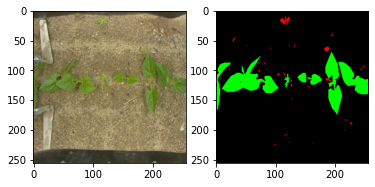

[0. 1. 2.]


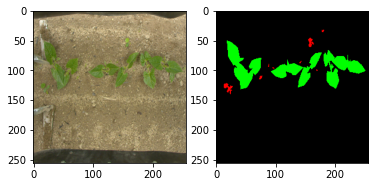

In [23]:
for k in range(2):
  # plot
  fig, ax = plt.subplots(1, 2)

  augmented_img, target = next(iterator)
  augmented_img = augmented_img[0]   # First element
  augmented_img = augmented_img  # denormalize


  target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

  print(np.unique(target))

  target_img = np.zeros([target.shape[0], target.shape[1], 3])

  target_img[np.where(target == 0)] = [0, 0, 0]
  target_img[np.where(target == 1)] = [0, 255, 0] 
  target_img[np.where(target == 2)] = [255, 0, 0] 

  ax[0].imshow(np.uint8(augmented_img))
  ax[1].imshow(np.uint8(target_img))

  plt.show()

In [24]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
  
num_classes = 3    
# input layer  


img_h = 256
img_w = 256

inputs = Input(shape = [img_h,img_w,3])


conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.1)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.1)(conv5)

up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(num_classes, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)


In [25]:
# Optimization params
# -------------------
import tensorflow.keras as K
# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 3e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
#meanIoU = tf.keras.metrics.MeanIoU(num_classes = 3)

def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(0,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)


# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [26]:
history = model.fit(x=train_dataset,
          epochs=10,  #### set repeat in training dataset
          steps_per_epoch=len(train)/batch_size,
          validation_data=valid_dataset,
          validation_steps=len(valid)/batch_size)

val_acc = history.history['val_accuracy']

Epoch 1/10
81/81 [==============================] - 243s 3s/step - loss: 2.3882 - accuracy: 0.8290 - meanIoU: 0.2801 - val_loss: 1.2327 - val_accuracy: 0.8975 - val_meanIoU: 0.3001
Epoch 2/10
81/81 [==============================] - 238s 3s/step - loss: 1.1763 - accuracy: 0.9052 - meanIoU: 0.3023 - val_loss: 1.2125 - val_accuracy: 0.8980 - val_meanIoU: 0.3002
Epoch 3/10
10/81 [==>...........................] - ETA: 1:11 - loss: 1.4504 - accuracy: 0.8694 - meanIoU: 0.2899

KeyboardInterrupt: 

In [42]:
import os
import json
import numpy as np
from PIL import Image



#test folder
test_dir = os.path.join("/kaggle/input/contadinoset/Development_Dataset","Test_Dev/Bipbip")

listOfFiles = []
for (dirpath, dirnames, filenames) in os.walk(test_dir):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    
# list of files contains all the directories of the test images 




test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

temp_test_folder = "/kaggle/working/test_temp"
temp_class_folder = os.path.join(temp_test_folder,"test")

submission_folder = "/kaggle/working/submission"


if not os.path.exists(submission_folder):
    os.mkdir(submission_folder)

if not os.path.exists(temp_test_folder):
    os.mkdir(temp_test_folder)
    
if not os.path.exists(temp_class_folder):
    os.mkdir(temp_class_folder)

    
for path in listOfFiles:
    image_name = (path.split('/'))[-1] 
    shutil.copy(path, os.path.join(temp_class_folder,image_name))

                                  


test_gen = test_data_gen.flow_from_directory(
    temp_test_folder,
    target_size=(img_w, img_h), 
    color_mode='rgb',
    classes = ['test'],
    batch_size=1,
    shuffle=False
    )

test_gen.reset()

images = test_gen.filenames


predictions = model.predict_generator(test_gen, len(test_gen), verbose=1)

print(predictions)

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



# The submission file will be a zip file containing the a
# submission.json file.

# It must have the following structure:

# - image name (without any extension, e.g., png, jpg, etc.)
#   - shape: shape of the original image as list [Height, Width]
#   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
#   - crop: crop of the original image. One in {'Haricot', 'Mais'}
#   - segmentation: prediction (as a dict)
#     - crop: RLE encoded crop segmentation (no weed)
#     - weed: RLE encoded weed segmentation (no crop)

# Please refer to the folder structure of the given dataset to fill
# the team and crop keys.

# EXAMPLE:

# Suppose that the numpy array generated with the
# 'read_mask_example.py' script is the output of your segmentation model.
# In addition, suppose that the team and crop of the segmented image
# are 'Bipbip' and 'Haricot', respectively.
# Then, in the following an example of submission file.

counter = 0

for p in predictions:
    img_name = images[counter]

    # load mask <- HERE you should have your segmentation model instead
    #mask_arr = np.load('./predictions/arr_mask_example.npy')
    mask_arr = p
    submission_dict = {}
    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = p.shape
    submission_dict[img_name]['team'] = 'Bipbip'
    submission_dict[img_name]['crop'] = 'Haricot'
    submission_dict[img_name]['segmentation'] = {}

    # RLE encoding
    # crop
    rle_encoded_crop = rle_encode(mask_arr == 1)
    # weed
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

    # Please notice that in this example we have a single prediction.
    # For the competition you have to provide segmentation for each of
    # the test images.
    
    counter += 1
    
    
os.rmdir(os.path.join(submission_folder,'submission.json'))
    
# Finally, save the results into the submission.json file
with open(os.path.join(submission_folder,'submission.json'), 'w') as f:
    json.dump(submission_dict, f)






Found 120 images belonging to 1 classes.
120/120 [==============================] - 19s 162ms/step
[[[[0.64182216 0.48280382 0.45337474]
   [0.66533667 0.52439016 0.40202436]
   [0.67915064 0.4280801  0.4241319 ]
   ...
   [0.5264771  0.55403066 0.5090218 ]
   [0.4867199  0.5554747  0.5091737 ]
   [0.46983033 0.521343   0.49394995]]

  [[0.6589848  0.48758128 0.5950659 ]
   [0.60808295 0.54904777 0.5210912 ]
   [0.67282516 0.44331273 0.6039493 ]
   ...
   [0.5923811  0.4298243  0.51730716]
   [0.55667853 0.46450725 0.48501188]
   [0.5311326  0.46184683 0.48294201]]

  [[0.7292325  0.46731058 0.55513984]
   [0.5264668  0.48116922 0.44046345]
   [0.6518731  0.34517545 0.48410353]
   ...
   [0.5399656  0.4267402  0.5059096 ]
   [0.51713586 0.44611704 0.48115554]
   [0.49525258 0.47626707 0.4546455 ]]

  ...

  [[0.5160828  0.50603247 0.50869143]
   [0.50422263 0.46542594 0.48583275]
   [0.5935086  0.52078605 0.4824242 ]
   ...
   [0.52655286 0.46679568 0.49187014]
   [0.4502674  0.4681846

NotADirectoryError: [Errno 20] Not a directory: '/kaggle/working/submission/submission.json'